<a href="https://colab.research.google.com/github/ozcannrabia/feature-engineering/blob/main/outliers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# veri setinden çok fazla sapmış olan aykırı değerler.
# aykırı değerleri bulma yöntemleri ;
# 1 -> sektör
# 2 -> standart sapma
# 3 -> z-skoru
# 4 -> boxplot  (biz bunu kullanıcaz)

In [ ]:
!pip install missingno

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

In [ ]:
def load_application_train():
    data = pd.read_csv("application_train.csv")
    return data
df = load_application_train()


In [ ]:
def load():
    data = pd.read_csv("titanic.csv")
    return data
df = load()

Aykırı Değer Yakalama

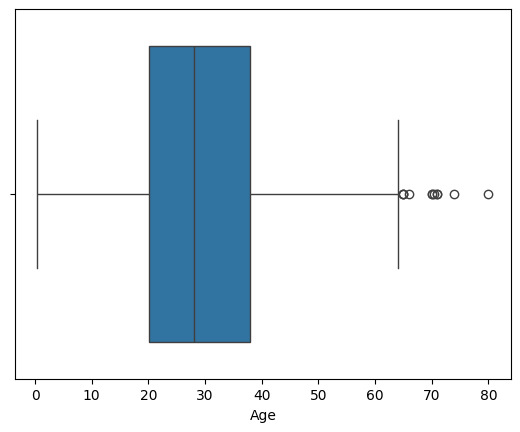

In [ ]:
sns.boxplot(x=df["Age"])
plt.show()

Aykırı Değer Nasıl Yakalanır ?

In [ ]:
q1 = df["Age"].quantile(0.25)
q3 = df["Age"].quantile(0.75)
iqr = q3 - q1
upper = q3 + 1.5 * iqr
lower = q1 - 1.5 * iqr
df[(df["Age"] > upper) | (df["Age"] < lower)].index

Index([33, 54, 96, 116, 280, 456, 493, 630, 672, 745, 851], dtype='int64')

Çoklu Aykırı Değer Yakalama

In [ ]:
# aykırı değerleri bulma
def outlier_thresholds(dataframe, col_name, q1=0.25, q3=0.75):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquartile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquartile_range
    low_limit = quartile1 - 1.5 * interquartile_range
    return low_limit, up_limit

In [ ]:
# aykırı değer var mı sorgusu
def check_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
    return True
  else:
    return False

In [ ]:
# veri tiplerini belirleme
def grab_col_names(dataframe, cat_th=10, car_th=20):
  cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
  num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
  cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
  cat_cols = cat_cols + num_but_cat
  cat_cols = [col for col in cat_cols if col not in cat_but_car]

  num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
  num_cols = [col for col in num_cols if col not in num_but_cat]

  print(f"Observations: {dataframe.shape[0]}")
  print(f"Variables: {dataframe.shape[1]}")
  print(f'cat_cols: {len(cat_cols)}')
  print(f'num_cols: {len(num_cols)}')
  print(f'cat_but_car: {len(cat_but_car)}')
  print(f'num_but_cat: {len(num_but_cat)}')
  return cat_cols, num_cols, cat_but_car

In [ ]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [ ]:
for col in num_cols:
  print(col, check_outlier(df, col))

PassengerId False
Age True
Fare True


In [ ]:
# aykırı değerleri gösterme, tercihen indexli gösterme
def grab_outliers(dataframe, col_name, index=False):
  low, up = outlier_thresholds(dataframe, col_name)
  if dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].shape[0] > 10:
    print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].head())
  else:
    print(dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))])

  if index:
    outlier_index = dataframe[((dataframe[col_name] < low) | (dataframe[col_name] > up))].index
    return outlier_index

Aykırı Değer Problemi Çözme

Silme

In [ ]:
low, up = outlier_thresholds(df, "Fare")
df.shape

(891, 12)

In [ ]:
df[~((df["Fare"] < low) | (df["Fare"] > up))].shape

(775, 12)

In [ ]:
# aykırı değer silme
def remove_outlier(dataframe, col_name):
  low_limit, up_limit = outlier_thresholds(dataframe, col_name)
  df_without_outliers = dataframe[~((dataframe[col_name] < low_limit) | (dataframe[col_name] > up_limit))]
  return df_without_outliers

In [ ]:
for col in num_cols:
  new_df = remove_outlier(df, col)

In [ ]:
new_df.shape

(775, 12)

Baskılama

In [ ]:
low, up = outlier_thresholds(df, "Fare")
df[((df["Fare"] < low) | (df["Fare"] > up))]["Fare"]
df.loc[((df["Fare"] < low) | (df["Fare"] > up)), "Fare"]

df.loc[(df["Fare"] > up), "Fare"] = up
df.loc[(df["Fare"] < low), "Fare"] = low

In [ ]:
# aykırı değer doldurma
def replace_with_thresholds(dataframe, variable):
  low_limit, up_limit = outlier_thresholds(dataframe, variable)
  dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
  dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

En Baştan Bakalım

In [ ]:
df = load()
df.shape

(891, 12)

In [ ]:
# aykırı değer var mı bakıyoruz
for col in num_cols:
  print(col, check_outlier(df, col))

PassengerId False
Age True
Fare True


In [ ]:
# aykırı değer olduğunu gördük ve bunları baskılama yöntemiyle dolduruyoruz
for col in num_cols:
  replace_with_thresholds(df, col)

In [ ]:
# tekrar baktığımızda aykırı değer yok
for col in num_cols:
  print(col, check_outlier(df, col))

PassengerId False
Age False
Fare False


Local Outlier Factor -> Çok Değişkenli Aykırı Değer Analizi

In [ ]:
df = sns.load_dataset("diamonds")
df = df.select_dtypes(include=["float64", "int64"])
df = df.dropna()
df.head()

,carat,depth,table,price,x,y,z
0,0.23,61.5,55.0,326,3.95,3.98,2.43
1,0.21,59.8,61.0,326,3.89,3.84,2.31
2,0.23,56.9,65.0,327,4.05,4.07,2.31
3,0.29,62.4,58.0,334,4.20,4.23,2.63
4,0.31,63.3,58.0,335,4.34,4.35,2.75


In [ ]:
for col in df.columns:
  print(col, check_outlier(df, col))

carat True
depth True
table True
price True
x True
y True
z True


In [ ]:
low, up = outlier_thresholds(df, "carat")
df[((df["carat"] < low) | (df["carat"] > up))].shape

(1889, 7)

In [ ]:
lof = LocalOutlierFactor(n_neighbors=20)
lof.fit_predict(df)

df_scores = lof.negative_outlier_factor_
df_scores[0:10]

array([-1.58352526, -1.59732899, -1.62278873, -1.33002541, -1.30712521,
       -1.28408436, -1.28428162, -1.26458706, -1.28422952, -1.27351342])

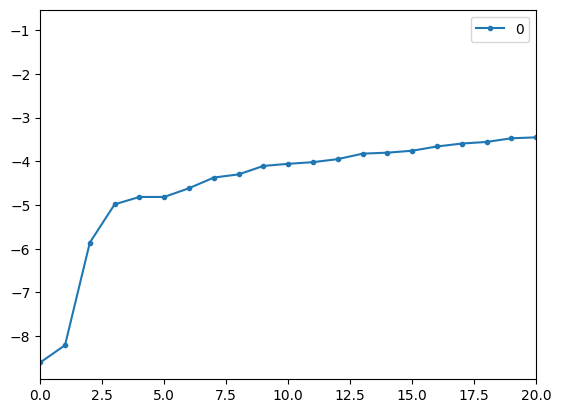

In [ ]:
# aykırı değer için eşik değer belirleme
# en bariz değişiklik -5 te olduğu için orayı eşik değer seçiyoruz
scores = pd.DataFrame(np.sort(df_scores))
scores.plot(stacked=True, xlim=[0, 20], style=".-")
plt.show()

In [ ]:
th = np.sort(df_scores)[3]
th

-4.984151747711709

In [ ]:
df[df_scores < th].shape

(3, 7)

In [ ]:
# silme
df[df_scores < th].drop(axis=0, labels=df[df_scores < th].index)

,carat,depth,table,price,x,y,z


In [ ]:
# baskılama
# gözlem sayısı çok olursa veri setine kendimiz veri eklersek gürültü çıkarmış oluruz
# gözlem sayısı az olursa da direkt veri setinden çıkarabiliriz
# sonuç olarak aykırı değer analizi yaparken 1 e 99 olarak th belirlersek çok aykırı olanları buluruz
# bu da bize az aykırı değer verir bunları silerek devam ederiz
# ağaç yöntemlerinde zaten aykırı değerlere dokunmuyoruz